# Combined model tsfresh

In [2]:
import pandas as pd
import numpy as np

from tsfresh.feature_extraction import extract_features, EfficientFCParameters, MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from tsfresh.feature_selection import select_features
from tsfresh.feature_extraction.settings import from_columns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

from pyts.transformation import BOSS

from catboost import CatBoostClassifier

from spark.preprocessor import preprocessor

In [3]:
raw_data_prep_dir = '../raw_data/pads-parkinsons-disease-smartwatch-dataset-1.0.0/preprocessed/'

In [4]:
file_list = pd.read_csv(raw_data_prep_dir  + "file_list.csv")
file_list

,resource_type,id,study_id,condition,disease_comment,age_at_diagnosis,age,height,weight,gender,handedness,appearance_in_kinship,appearance_in_first_grade_kinship,effect_of_alcohol_on_tremor,label
0,patient,1,PADS,Healthy,-,56,56,173,78,male,right,True,True,Unknown,0
1,patient,2,PADS,Other Movement Disorders,Left-Sided resting tremor and hypokinesia with...,69,81,193,104,male,right,False,NaN,No effect,2
2,patient,3,PADS,Healthy,-,45,45,170,78,female,right,False,NaN,Unknown,0
3,patient,4,PADS,Parkinson's,IPS akinetic-rigid type,63,67,161,90,female,right,False,NaN,No effect,1
4,patient,5,PADS,Parkinson's,IPS tremordominant type,65,75,172,86,male,left,False,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,patient,465,PADS,Parkinson's,IPS mixed type,62,65,175,80,male,right,True,False,No effect,1
465,patient,466,PADS,Healthy,-,84,84,172,74,female,right,True,True,No effect,0
466,patient,467,PADS,Parkinson's,"Essential Tremor, starting IPS tremordominant ...",55,57,190,100,male,right,False,NaN,Improvement,1
467,patient,468,PADS,Parkinson's,IPS mixed type,73,76,198,118,male,right,False,NaN,No effect,1


In [10]:
X_train_q, X_test_q, y_train_q, y_test_q = preprocessor("~/code/marzecovaa/spark/processed_data/merged_dfq.csv")

✅ Transformer saved at: ./model_registry/transformer_20250909-112742.joblib


In [6]:
def load_time_series_data(file_list):

    time_data = []
    y = []
    X_to_split = []

    for idx, subject_idx in enumerate(file_list['id']):
        file_name = raw_data_prep_dir + f'movement/{subject_idx:03d}_ml.bin'
        time_idx_data = np.fromfile(file_name, dtype=np.float32).reshape((-1, 976))
        time_data.append(time_idx_data)
        y_idx = file_list[file_list['id']==subject_idx].label.values
        X_id = idx
        y.append(y_idx)
        X_to_split.append(X_id)
    X_to_split = np.array(X_to_split)
    y = np.array(y).flatten()
    time_data = np.array(time_data)
    return time_data, X_to_split, y

time_data = []
y = []
X_to_split = []


In [16]:
time_data, X_to_split, y = load_time_series_data(file_list)

In [17]:
time_data.shape

(469, 132, 976)

In [18]:
X_train_idx, X_test_idx, y_train, y_test = train_test_split(X_to_split, y, test_size=0.20, random_state=42, stratify = y)
X_train = time_data[X_train_idx]
X_test = time_data[X_test_idx]
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))
X_train.shape

375 94
375 94


(375, 132, 976)

In [ ]:
# shape (N, F, T)
N, F, T = X_test.shape
feature_names = [f"feat_{i}" for i in range(F)]

def make_long_df(batch_data: np.ndarray, id_offset: int = 0) -> pd.DataFrame:

    n_batch = batch_data.shape[0]


    x = np.transpose(batch_data, (0, 2, 1))
    values = x.reshape(-1)

    ids = np.repeat(np.arange(id_offset, id_offset + n_batch), T * F)


    times = np.tile(np.repeat(np.arange(T), F), n_batch)


    kinds_idx = np.tile(np.arange(F), n_batch * T)
    kinds = np.array(feature_names, dtype=object)[kinds_idx]

    return pd.DataFrame({"id": ids, "time": times, "kind": kinds, "value": values})

df_long_train  = make_long_df(X_train, id_offset=0)
df_long_test = make_long_df(X_test, id_offset=0)
df_long = make_long_df(time_data, id_offset=0)


In [52]:
X_features = extract_features(
     df_long,
     column_id="id",
     column_sort="time",
     column_kind="kind",
     column_value="value",
     default_fc_parameters=EfficientFCParameters(),
     n_jobs=0
)

print(X_features.shape)  # (375, num_features)
X_features.to_csv('X_features_efficient.csv')

Feature Extraction: 100%|██████████| 61908/61908 [1:09:31<00:00, 14.84it/s]  


(469, 102564)


In [53]:
df_long_train.head
X_train_features = pd.read_csv('X_features_fresh.csv')

In [34]:
y_series = pd.Series(y_train, index=X_train_features.index)
classes = np.unique(y_series)
X_train_features_clean = X_train_features.copy()
X_train_features_clean = X_train_features_clean.dropna(axis=1)

selected_sets = []
for c in classes:
    y_bin = (y_series == c).astype(int)
    sel_c = select_features(X_train_features_clean, y_bin, fdr_level=0.001)
    selected_sets.append(set(sel_c.columns))

selected_cols = sorted(set().union(*selected_sets))
X_train_selected = X_train_features[selected_cols]
print(f"Selected {len(selected_cols)} / {X_train_features.shape[1]} features")

Selected 2179 / 102565 features


In [55]:
X_train_selected.head()

,feat_0__benford_correlation,feat_102__number_peaks__n_5,feat_107__skewness,"feat_10__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""",feat_10__autocorrelation__lag_6,feat_10__autocorrelation__lag_7,feat_10__autocorrelation__lag_8,feat_10__autocorrelation__lag_9,feat_10__longest_strike_below_mean,feat_10__number_peaks__n_1,...,"feat_95__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4","feat_95__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",feat_95__number_cwt_peaks__n_1,feat_95__number_peaks__n_1,feat_95__permutation_entropy__dimension_3__tau_1,feat_95__permutation_entropy__dimension_4__tau_1,feat_95__permutation_entropy__dimension_5__tau_1,feat_95__permutation_entropy__dimension_6__tau_1,feat_95__permutation_entropy__dimension_7__tau_1,feat_95__quantile__q_0.7
0,0.988203,54.0,0.128053,-0.008443,0.294999,0.222363,0.178213,0.157058,30.0,247.0,...,0.000016,0.000014,74.0,139.0,1.488744,2.426053,3.416664,4.346878,5.122478,0.017116
1,0.993024,67.0,-0.049709,-0.010706,0.439804,0.432958,0.372735,0.314253,40.0,209.0,...,0.000005,0.000003,63.0,143.0,1.505316,2.425822,3.397717,4.304739,5.120072,0.005144
2,0.995863,64.0,-0.026702,-0.000233,0.379958,0.318195,0.292872,0.298987,113.0,203.0,...,0.000008,0.000011,67.0,153.0,1.530110,2.469468,3.454752,4.356283,5.083911,0.016538
3,0.908795,65.0,-0.556466,-0.026849,-0.232763,-0.428265,-0.551131,-0.596038,25.0,119.0,...,0.000035,0.000045,55.0,118.0,1.413186,2.234390,3.096794,3.876391,4.579338,0.054862
4,0.952341,58.0,-0.535556,-0.008075,-0.121153,-0.261847,-0.336446,-0.351019,20.0,172.0,...,0.000010,0.000007,57.0,115.0,1.403406,2.224105,3.081548,3.935594,4.718412,0.005430


In [54]:
X_test_features = extract_features(
    df_long_test,
    column_id="id",
    column_sort="time",
    column_kind="kind",
    column_value="value",
    default_fc_parameters=EfficientFCParameters(),
    n_jobs=0
)

print(X_test_features.shape)  # (375, num_features)

Feature Extraction: 100%|██████████| 12408/12408 [14:08<00:00, 14.62it/s]


(94, 102564)


In [ ]:
X_test_features.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [7]:
X = pd.read_csv("X_features_efficient.csv")
X.shape

(469, 102565)

In [66]:
X_clean = X.copy()
X_clean = X_clean.dropna(axis= 1)
X_clean.shape
X_clean_train = X_clean.iloc[X_train_idx,:]
X_clean_train.shape

(375, 102433)

In [95]:
y_series = pd.Series(y_train, index=X_clean_train.index)
classes = np.unique(y_series)

selected_sets = []
for c in classes:
    y_bin = (y_series == c).astype(int)
    sel_c = select_features(X_clean_train, y_bin, fdr_level=0.0000001)
    selected_sets.append(set(sel_c.columns))

selected_cols = sorted(set().union(*selected_sets))
X_train_selected = X_clean_train[selected_cols]
print(f"Selected {len(selected_cols)} / {X_train_features.shape[1]} features")

Selected 118 / 102565 features


In [134]:
X_train_selected.columns[-1]

'feat_94__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4'

In [98]:
X_clean_test = X_clean.iloc[X_test_idx,:]
X_clean_test.shape
X_test_selected = X_clean_test[selected_cols]

In [99]:
X_test_selected.shape


(94, 118)

In [ ]:
#pca = PCA(n_components = 150, random_state = 23)

In [116]:
mm_scaler = MinMaxScaler()
X_train_selected_prep = mm_scaler.fit_transform(X_train_selected)
X_test_selected_prep = mm_scaler.transform(X_test_selected)

In [117]:
X_combined_train = np.concatenate((X_train_selected_prep, X_train_q), axis = 1)
X_combined_test = np.concatenate((X_test_selected_prep, X_test_q), axis = 1)
X_combined_train.shape

(375, 156)

In [118]:
sv_model_combined = SVC(kernel = 'rbf', class_weight = 'balanced', C = 1)
sv_model_combined.fit(X_combined_train, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [125]:
y_pred_combo_sv = sv_model_combined.predict(X_combined_test)

In [126]:
balanced_accuracy_score(y_test, y_pred_combo_sv)

0.7941864295125165

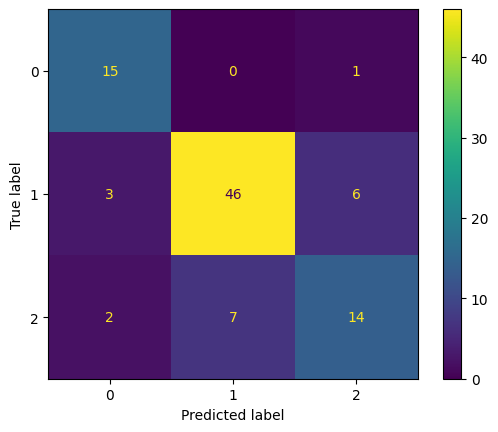

In [127]:
cm_svc = confusion_matrix(y_test,y_pred_combo_sv)
disp_cm_svc  = ConfusionMatrixDisplay(cm_svc)
disp_cm_svc.plot();

In [123]:
cat_model_pca = CatBoostClassifier(iterations = 2000,
                                    learning_rate = 0.05,
                                    depth = 7)
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

cat_model_pca.fit(X_combined_train, y_train,
                  eval_set = (X_combined_test, y_test),
                  use_best_model = True,
                  sample_weight=sample_weights)

0:	learn: 1.0728779	test: 1.0862554	best: 1.0862554 (0)	total: 25.9ms	remaining: 51.7s
1:	learn: 1.0536631	test: 1.0794883	best: 1.0794883 (1)	total: 41.8ms	remaining: 41.8s
2:	learn: 1.0314061	test: 1.0689952	best: 1.0689952 (2)	total: 56.3ms	remaining: 37.5s
3:	learn: 1.0119398	test: 1.0602412	best: 1.0602412 (3)	total: 69.2ms	remaining: 34.5s
4:	learn: 0.9959979	test: 1.0512701	best: 1.0512701 (4)	total: 83.4ms	remaining: 33.3s
5:	learn: 0.9806905	test: 1.0475623	best: 1.0475623 (5)	total: 99.1ms	remaining: 32.9s
6:	learn: 0.9672425	test: 1.0411034	best: 1.0411034 (6)	total: 115ms	remaining: 32.8s
7:	learn: 0.9529772	test: 1.0321922	best: 1.0321922 (7)	total: 131ms	remaining: 32.6s
8:	learn: 0.9395090	test: 1.0263648	best: 1.0263648 (8)	total: 144ms	remaining: 31.9s
9:	learn: 0.9253473	test: 1.0185163	best: 1.0185163 (9)	total: 160ms	remaining: 31.8s
10:	learn: 0.9126863	test: 1.0135257	best: 1.0135257 (10)	total: 176ms	remaining: 31.8s
11:	learn: 0.8999525	test: 1.0098824	best: 1.0

In [114]:
y_pred_cat = cat_model_pca.predict(X_combined_test)

In [115]:
cat_accuracy = balanced_accuracy_score(y_test, y_pred_cat)
f'cat_accuracy: {cat_accuracy}'

'cat_accuracy: 0.7377470355731225'